## Imports

In [11]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [12]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [13]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Cross-validation

In [15]:
svm = SVC()
scores_svm = cross_validate(svm, X, y, cv=cv, scoring=scoring_metrics)

print("Scores SVM:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_svm[f"test_{metric}"])
    std_score = np.std(scores_svm[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores SVM:
Accuracy: 0.8356 ± 0.0992
Precision: 0.8409 ± 0.1225
Recall: 0.7826 ± 0.1152
Fbeta_2: 0.7928 ± 0.1138
Roc_auc: 0.9039 ± 0.0826


## Bayesian Optimization

In [16]:
search_space = {
    'C': (0.1, 100),  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': (2, 5),  # Degree of the polynomial kernel (only used for 'poly')
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'coef0': (0, 10)  # Independent term in kernel function (only used for 'poly' and 'sigmoid')
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up Bayesian Optimization for SVM
opt_svm = BayesSearchCV(
    SVC(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_svm.fit(X, y)

best_params = opt_svm.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_svm.best_score_)

Best parameters: OrderedDict([('C', 0.1), ('coef0', 4), ('degree', 2), ('gamma', 'auto'), ('kernel', 'linear')])
Best ROC AUC score (cv): 0.9080151590871232


## Cross-validation with best model

In [17]:
svm = SVC(**best_params, probability=True)
scores_svm = cross_validate(svm, X, y, cv=cv, scoring=scoring_metrics)

print("Scores SVM:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_svm[f"test_{metric}"])
    std_score = np.std(scores_svm[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores SVM:
Accuracy: 0.8430 ± 0.1001
Precision: 0.8297 ± 0.0968
Recall: 0.8080 ± 0.1454
Fbeta_2: 0.8113 ± 0.1348
Roc_auc: 0.9080 ± 0.0809


## Feature Importance | SHAP

Using 214 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/54 [00:00<?, ?it/s]

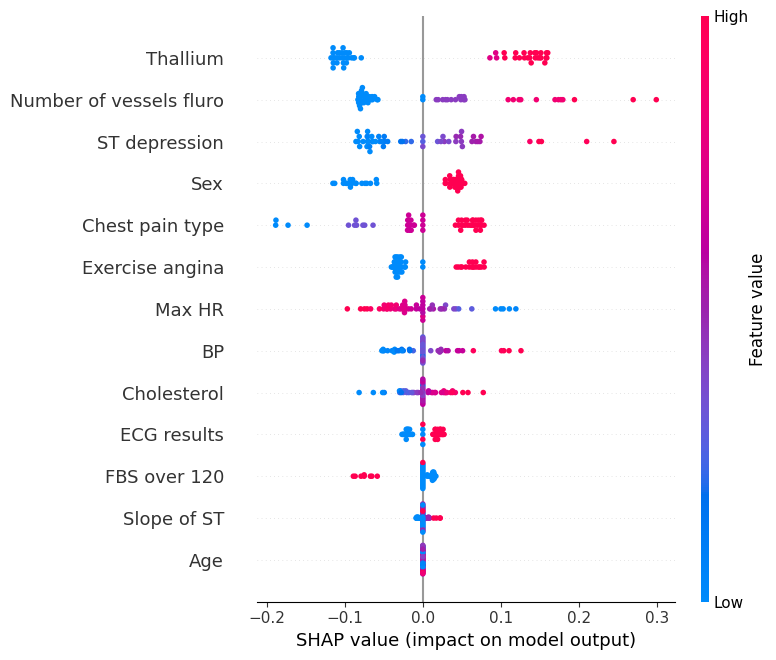

In [18]:
# Train nb model
svm.fit(X_train, y_train)

# Sample for SHAP
X_sample = X_test # X_test[:10]

# Use only the class 1 probability output for SHAP
predict_fn = lambda x: svm.predict_proba(x)[:, 1]

# KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_train) # X_train[:100]
shap_values = explainer.shap_values(X_sample)

# Plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)